# Let's do some biomechanics !!

Now, we are working with a arm model, actuated by muscles and pure joint torques (to compensate for model weakness). 
The goal is, starting from an initial position, to perform a reaching  task with this arm, by superimposing two markers. 
The first one (called 'target' in the model), is fixed in the scene.
The second one (called 'COM_hand' in the model) is fixed on the arm, in the *ulna* coordinate system.

The ocp to solve is as follow:
- Movement of $3s$ divided into $50$ shooting points
- The state variables are the generalized position (q) and velocities (qdot)
- The control variables are the muscle activations (a) 
- Cost functions: minimize the control effort at all time and minimize the squared Euclidean distance between the two markers at the final node
- Initial guess is arbitrarily set to $0.5$ for muscle activations and to $0$ for all other variables

In [1]:
# So first, let's import all the required classes 
import biorbd
from bioptim import *

In [16]:
# Let's define the OCP
final_time= 3
n_shooting = 50

# Load the model and define some aliases
model = biorbd.Model("models/arm26.bioMod")
nq = model.nbQ()
ndq = model.nbQdot()
ntau = model.nbGeneralizedTorque()
nmus = model.nbMuscleTotal()

# Add objective functions
objective_functions = ObjectiveList()
objective_functions.add(ObjectiveFcn.Lagrange.MINIMIZE_TORQUE, weight=10)
objective_functions.add(ObjectiveFcn.Lagrange.MINIMIZE_MUSCLES_CONTROL)
objective_functions.add(
    ObjectiveFcn.Mayer.SUPERIMPOSE_MARKERS, first_marker='COM_hand', second_marker='target', weight=1e9
)

# Dynamics
dynamics = DynamicsList()
dynamics.add(DynamicsFcn.MUSCLE_ACTIVATIONS_AND_TORQUE_DRIVEN)

# Path constraint
x_bounds = BoundsList()
x_bounds.add(bounds=QAndQDotBounds(model))
x_bounds[0][:, 0] = (0.07, 1.4, 0, 0)

# Initial guess
x_init = InitialGuessList()
x_init.add([1.57] * nq + [0] * ndq)

# Define control path constraint
muscle_min, muscle_max, muscle_init = 0, 1, 0.5
tau_min, tau_max, tau_init = -5, 5, 0
u_bounds = BoundsList()
u_bounds.add(
    [tau_min] * ntau + [muscle_min] * nmus,
    [tau_max] * ntau + [muscle_max] * nmus,
)

u_init = InitialGuessList()
u_init.add([tau_init] * ntau + [muscle_init] * nmus)
# ------------- #

ocp = OptimalControlProgram(
    model,
    dynamics,
    n_shooting,
    final_time,
    x_init,
    u_init,
    x_bounds,
    u_bounds,
    objective_functions,
    n_threads = 8,
)


In [17]:
sol = ocp.solve()

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2584
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3861

Total number of variables............................:      600
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      600
                     variables with only upper bounds:        0
Total number of equality constraints.................:      200
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

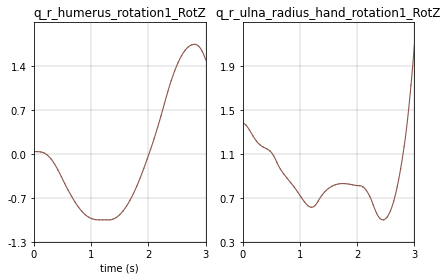

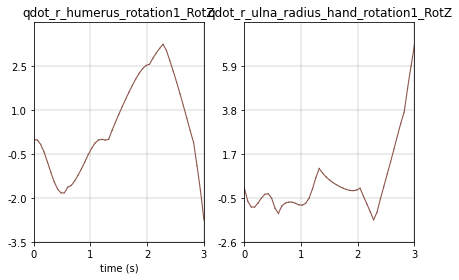

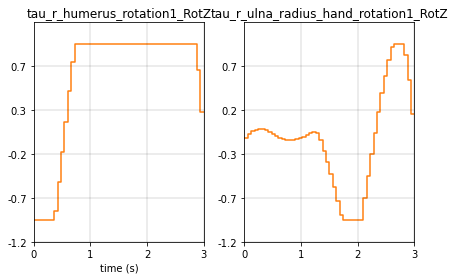

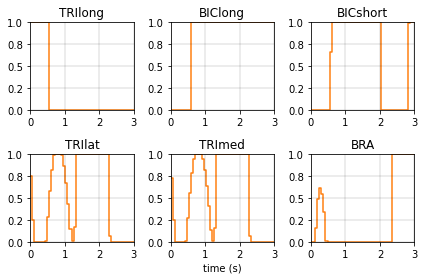

In [4]:
sol.graphs(automatically_organize=False)

In [7]:
# sol.animate()
# This would work locally on your computer. Unfortunately, it is nor currently working with remote notebooks...
# Call one of the workshop organizers, so you can see the motion animation.

In [18]:
sol.print()

Solving time: 21.389864206314087 sec
Elapsed time: 21.389864206314087 sec

---- COST FUNCTION VALUES ----
PHASE 0
MINIMIZE_TORQUE: 146.83944110588453 (weighted 88.1037)
MINIMIZE_MUSCLES_CONTROL: 150.6957120840864 (weighted 9.04174)
SUPERIMPOSE_MARKERS: 0.0008742888940723458 (weighted 874289)

Sum cost functions: 874386
------------------------------

--------- CONSTRAINTS ---------
CONTINUITY 0: -8.629651191728593e-08

PHASE 0

------------------------------


Let us compute the distance between the two markers at the end of the motion, based on the information printed in the console above. Keep in mind that SUPERIMPOSE_MARKERS is a quadratic cost.


In [20]:
import numpy as np
dist = ...
print(f"At the final node, the distance between the 2 markers is {dist}m")

At the final node, the distance between the 2 markers is Ellipsism


You find it too large ? Try to solve the problem again by increasing the weight of the objective on the markers matching !

In [19]:
...

Ellipsis